<a href="https://colab.research.google.com/github/astrohayley/favorite-notebooks/blob/main/Predicting_Redshifts_with_SDSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Redshifts with SDSS

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
from astropy.table import Table as t
import os

plot = lambda: sns.set(context='paper', font_scale=1.2, style='ticks', palette = 'Dark2', 
        rc={'figure.figsize':(5,3), 'xtick.bottom': True, 'ytick.left':True, 
        'figure.dpi':150, 'figure.facecolor':'w', 'errorbar.capsize': 2, 
        'xtick.direction': 'in', 'ytick.direction': 'in', 'font.family': 'monospace'})

plot()

In [25]:
rng = np.random.RandomState(123)

## Using SDSS Photometry

Below queries SDSS using SQL where the `(s.htmid*37 & 0x000000000000FFFF) < (650 * 10)` clause substitutes for `sort by random()` - found from SDSS's website [here](https://classic.sdss.org/dr7/tutorials/random/index.html). By the factor of 10 that's multiplied, this pulls a sample that's 10% of the entire sample.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from astroquery.sdss import SDSS

In [61]:
query = """
select 
    s.bestobjid, s.ra, s.dec, s.z as zsp, s.class, s.sourceType,
    p.u, p.g, p.r, p.i, p.z, p.err_u, p.err_g, p.err_r, p.err_i, p.err_z
from photoObj as p 
    join specObj as s on s.bestobjid=p.objid
where s.class='galaxy' and s.zWarning=0 and (s.htmid*37 & 0x000000000000FFFF) < (650 * 10)
"""

data = SDSS.query_sql(query)

/usr/local/lib/python3.8/dist-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


Mask sources that have poor photometry measurements.

In [ ]:
perr_u = data['err_u']/data['u']
perr_g = data['err_g']/data['g']
perr_r = data['err_r']/data['r']
perr_i = data['err_i']/data['i']
perr_z = data['err_z']/data['z']

best_mags = (perr_u<=0.05) & (perr_g<=0.05) & (perr_r<=0.05) & (perr_i<=0.05) & (perr_z<=0.05)

This leaves a total of 181132 sources. Below is a histogram of their spectroscopic redshifts.

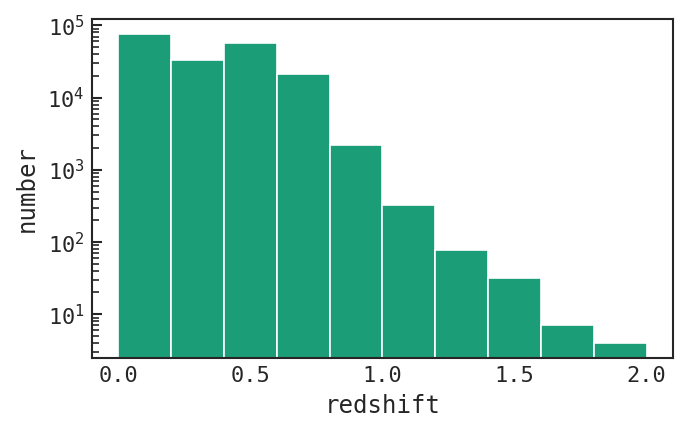

In [ ]:
plt.hist(data[best_mags]['zsp'], log=True)
plt.xlabel('redshift')
plt.ylabel('number')
plt.show()

Prep data for `sklearn` by converting to a pandas dataframe and selecting the features to use. Then let's split up the data into testing and training sets.

In [ ]:
# create dataframe that plays nicely with sklearn
df = data[best_mags].to_pandas(index=False)

# features to learn on
feature_names = ['u','g','r','i','z']
X = df[feature_names]
y = df['zsp']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# normalize
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Fit model and get the R2 score. This uses the `HuberRegressor` which is a linear regression model that is robust to outliers.

In [ ]:
# set up and fit model
regr = linear_model.HuberRegressor()
regr.fit(X_train, y_train)
# make prediction
y_pred = regr.predict(X_test)
r2 = r2_score(y_test, y_pred)

Text(0.5, 0, 'spectroscopic redshift')

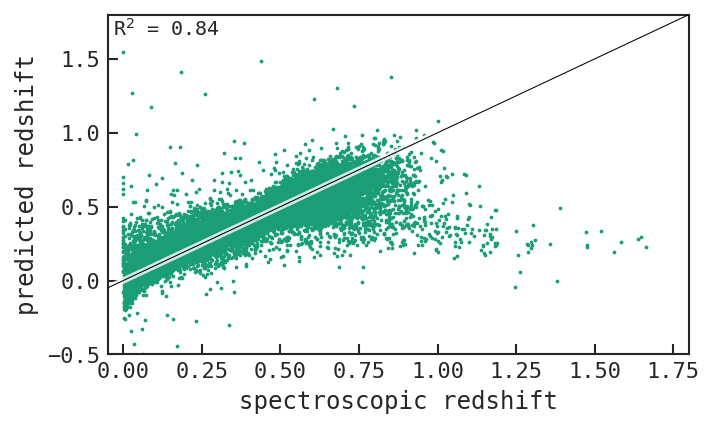

In [ ]:
plt.scatter(y_test, y_pred, zorder=1, s=1)
ylims = plt.gca().get_ylim()
xlims = plt.gca().get_xlim()
plt.plot([-1,5],[-1,5], color='k', linewidth=0.5, zorder=3)
plt.plot([-1,5],[-1,5], color='w', linewidth=3, alpha=0.8, zorder=2)
plt.ylim(-0.5,1.8)
plt.xlim(-0.05,1.8)
plt.text(0.01, 0.99,'R$^2$ = '+str(np.round(r2,2)), transform=plt.gca().transAxes, va='top', fontsize='small')
plt.ylabel('predicted redshift')
plt.xlabel('spectroscopic redshift')

Which magnitudes were the most important for determining the redshift?

Text(0.5, 0, 'importance (relative)')

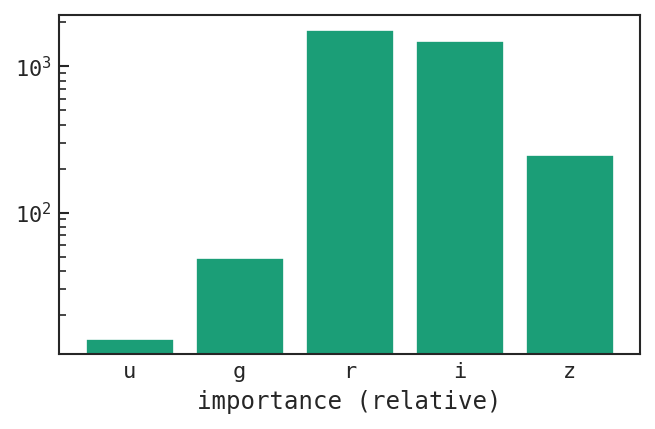

In [ ]:
feature_importance = permutation_importance(regr, X.values, y.values, n_repeats=50,random_state=123)

plt.bar(range(len(feature_names)), np.abs(feature_importance.importances_mean))
plt.xticks(range(len(feature_names)), labels=feature_names)
plt.yscale('log')
plt.xlabel('band')
plt.xlabel('relative importance')

## Using SDSS Images

Can we use fast.ai and SDSS color images I have downloaded to do this?  

In [ ]:
from fastai.basics import *
from fastai.vision.all import *
torch.device('cuda')

rng = np.random.RandomState(123)

SDSS color images I have downloaded come from the Galaxy Zoo 2 catalog, found [here](https://data.galaxyzoo.org/).  

In [29]:
!wget https://gz2hart.s3.amazonaws.com/gz2_hart16.fits.gz
!wget https://zooniverse-data.s3.amazonaws.com/galaxy-zoo-2/gz2sample.fits.gz

--2023-02-03 06:25:03--  https://gz2hart.s3.amazonaws.com/gz2_hart16.fits.gz
Resolving gz2hart.s3.amazonaws.com (gz2hart.s3.amazonaws.com)... 52.217.204.217, 52.217.135.73, 52.216.81.48, ...
Connecting to gz2hart.s3.amazonaws.com (gz2hart.s3.amazonaws.com)|52.217.204.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66801851 (64M) [application/x-gzip]
Saving to: ‘gz2_hart16.fits.gz’

gz2_hart16.fits.gz  100%[===================>]  63.71M  12.1MB/s    in 6.7s    

2023-02-03 06:25:11 (9.47 MB/s) - ‘gz2_hart16.fits.gz’ saved [66801851/66801851]



In [46]:
data_gz = t.read('gz2_hart16.fits.gz')

data_gz_meta = t.read('gz2sample.fits.gz')
data_gz_meta['OBJID'].name = 'dr7objid'
data_gz_meta['REDSHIFT'].name = 'zsp'
data_gz_meta['REDSHIFTERR'].name = 'err_zsp'

from astropy.table import join
data_gz = join(data_gz, data_gz_meta['dr7objid', 'zsp', 'err_zsp'], join_type='left', keys='dr7objid')
data_gz.add_index('dr7objid')

Grab the SDSS images and then match them to the catalog

In [55]:
!wget -q -nc -O sdss_images.tar.gz https://www.dropbox.com/s/cx2tub0wocmisu2/sdss_small.tar.gz?dl=0
!tar xzf sdss_images.tar.gz

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:_kMDItemUserTags'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'


In [42]:
import glob
downloaded_files = glob.glob('sdss_small/*.jpg')

downloaded = []
for file in downloaded_files:
    objid = int(file.split('/')[1].split('.jpg')[0])
    if objid in data_gz['dr7objid']:
        downloaded.append(int(objid))

An example of what these look like

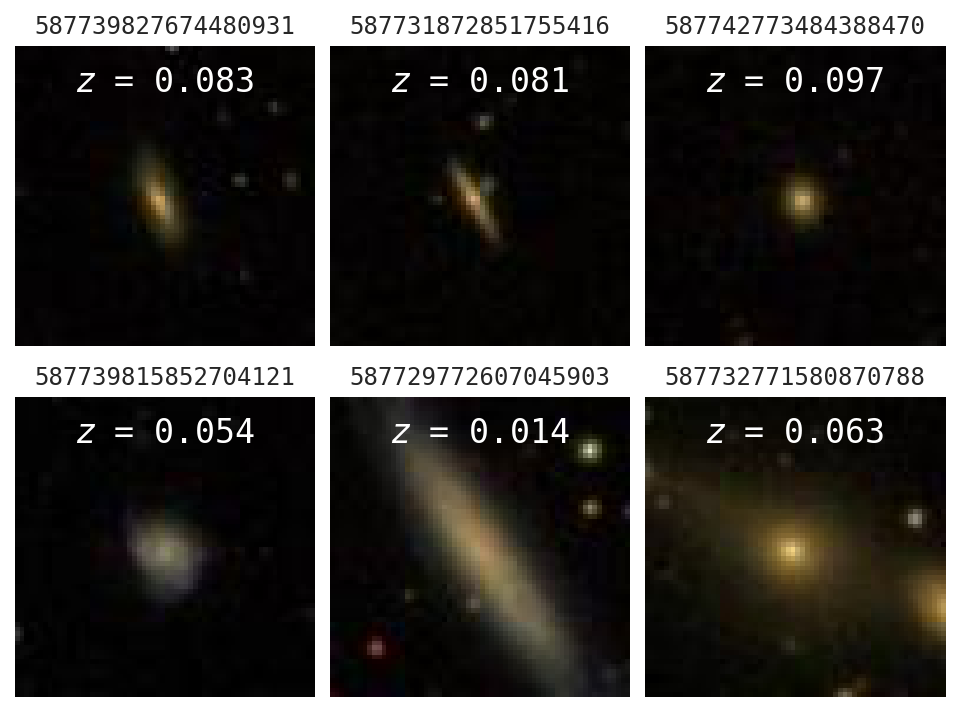

In [48]:
df = data_gz.loc[downloaded].to_pandas(index=False)
n_galaxies = len(df)

fig, axes = plt.subplots(2, 3, figsize=(8, 6), dpi=150)
for i, ax in zip(rng.choice(range(n_galaxies), size=6, replace=False), axes.flat):

    objID = df.iloc[i]['dr7objid']
    PILImage.create(f'sdss_small/{objID}.jpg').show(ax=ax, title=objID)
    z = df.iloc[i]['zsp']
    ax.text(0.5, 0.85, f'$z$ = {z:.3f}', ha='center', transform=ax.transAxes, size=16, color='white')

fig.subplots_adjust(wspace=0.05, hspace=0.07)

These have a much more limited redshift range however

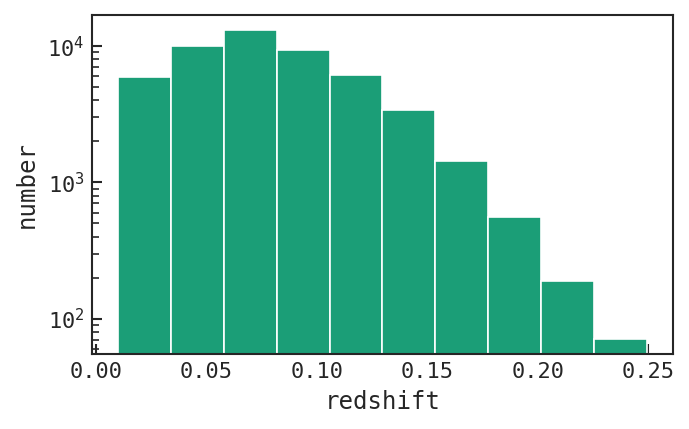

In [49]:
plt.hist(df['zsp'], log=True)
plt.xlabel('redshift')
plt.ylabel('number')
plt.show()

Load in images, apply transformations, and show an example batch

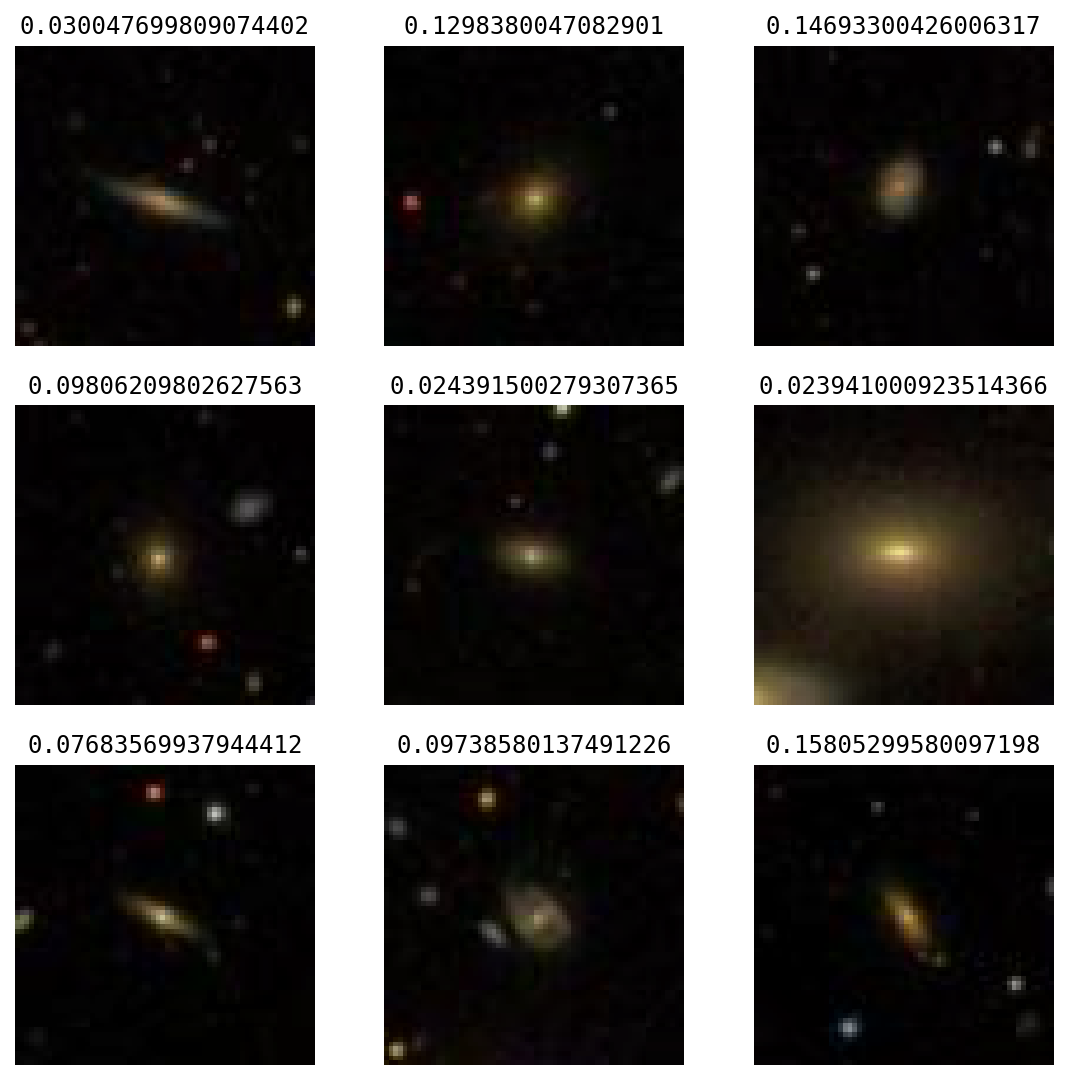

In [50]:
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader('dr7objid', pref='sdss_small/', suff='.jpg'),
    get_y=ColReader('zsp'),
    splitter=RandomSplitter(0.2, seed=123),
    batch_tfms=aug_transforms(do_flip=True, flip_vert=True, max_rotate=0, max_zoom=1.0, max_warp=0, p_lighting=0) + [Normalize()])

dls = ImageDataLoaders.from_dblock(dblock, df, bs=64)
dls.show_batch()

Setting up the model (residual neural net, [He+2015](https://arxiv.org/abs/1512.03385)), loss function, and learner. 

In [51]:
def RMSE(p, y): 
    return torch.sqrt(MSELossFlat()(p, y))

cnn_model = xresnet18(n_out=1, sa=True, act_cls=Mish)

learn = Learner(dls,cnn_model,loss_func=RMSE,opt_func=Adam).to_fp16()

Find the recommended learning rate

SuggestedLRs(valley=0.00019054606673307717)

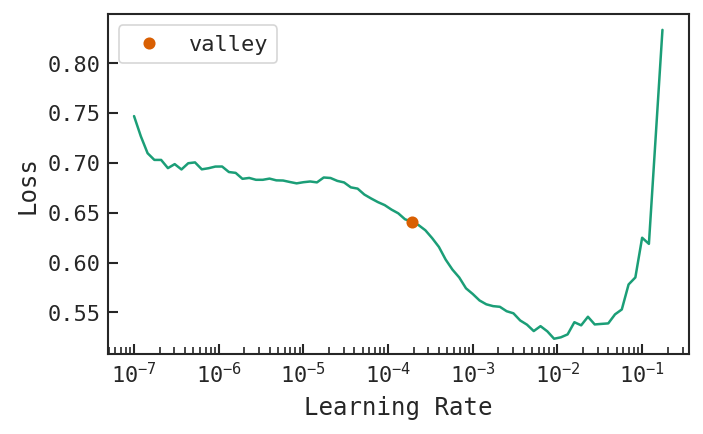

In [52]:
learn.lr_find()

In [56]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,0.059824,0.069995,01:17
1,0.036711,0.043183,01:15
2,0.027671,0.039246,01:15
3,0.024651,0.026787,01:16
4,0.023031,0.026189,01:15
5,0.022088,0.021562,01:15
6,0.021543,0.019494,01:16
7,0.019970,0.019547,01:15
8,0.019780,0.018866,01:15
9,0.019106,0.018689,01:15


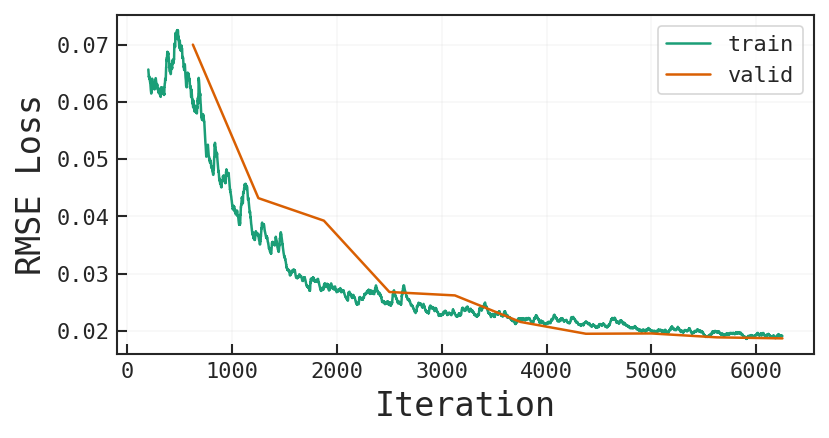

In [57]:
fig = plt.figure(figsize=(6, 3), dpi=150)

learn.recorder.plot_loss(skip_start=200)

plt.xlabel('Iteration', fontsize=16)
plt.ylabel('RMSE Loss', fontsize=16)
plt.grid(alpha=0.15);

In [58]:
z_pred, z_true = learn.get_preds()

Text(0.5, 0, 'spectroscopic redshift')

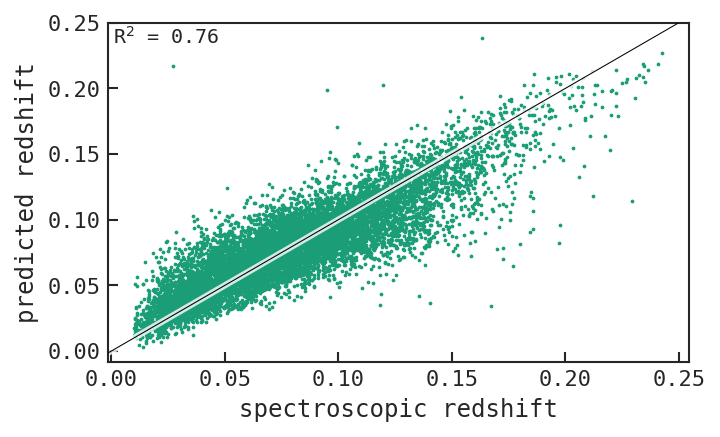

In [60]:
r2 = r2_score(z_true, z_pred)
plt.scatter(z_true, z_pred, zorder=1, s=1)
ylims = plt.gca().get_ylim()
xlims = plt.gca().get_xlim()
plt.plot([-1,5],[-1,5], color='k', linewidth=0.5, zorder=3)
plt.plot([-1,5],[-1,5], color='w', linewidth=3, alpha=0.8, zorder=2)
plt.ylim(ylims)
plt.xlim(xlims)
plt.text(0.01, 0.99,'R$^2$ = '+str(np.round(r2,2)), transform=plt.gca().transAxes, va='top', fontsize='small')
plt.ylabel('predicted redshift')
plt.xlabel('spectroscopic redshift')